Tia Argento, James Ugorji

# Machine Learning Project

The goal of this project is to develop and implement machine learning algorithms for regression to predict the magnitude of earthquakes and binary classification for tsunamis events.

As far as the description of the data, there are **13** columns/attributes: **magnitude**, **cdi** (community decimal intensity), **mmi** (modified Mercalli intensity), **sig** (event significance score), **nst** (number of seismic monitoring stations), **dmin** (distance to nearest seismic station), **gap** (azimuthal gap between stations), **depth**, **latitude**, **longitude**, **year**, **month**, and **tsunami** (target variable). As well as 782 rows/records of data.

In [44]:
import pandas as pd
import numpy as np

In [47]:
tsunami = pd.read_csv('earthquake_data_tsunami.csv')
tsunami

,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami
0,7.0,8,7,768,117,0.509,17.0,14.000,-9.7963,159.596,2022,11,1
1,6.9,4,4,735,99,2.229,34.0,25.000,-4.9559,100.738,2022,11,0
2,7.0,3,3,755,147,3.125,18.0,579.000,-20.0508,-178.346,2022,11,1
3,7.3,5,5,833,149,1.865,21.0,37.000,-19.2918,-172.129,2022,11,1
4,6.6,0,2,670,131,4.998,27.0,624.464,-25.5948,178.278,2022,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,7.7,0,8,912,427,0.000,0.0,60.000,13.0490,-88.660,2001,1,0
778,6.9,5,7,745,0,0.000,0.0,36.400,56.7744,-153.281,2001,1,0
779,7.1,0,7,776,372,0.000,0.0,103.000,-14.9280,167.170,2001,1,0
780,6.8,0,5,711,64,0.000,0.0,33.000,6.6310,126.899,2001,1,0


In [48]:
tsunami.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   magnitude  782 non-null    float64
 1   cdi        782 non-null    int64  
 2   mmi        782 non-null    int64  
 3   sig        782 non-null    int64  
 4   nst        782 non-null    int64  
 5   dmin       782 non-null    float64
 6   gap        782 non-null    float64
 7   depth      782 non-null    float64
 8   latitude   782 non-null    float64
 9   longitude  782 non-null    float64
 10  Year       782 non-null    int64  
 11  Month      782 non-null    int64  
 12  tsunami    782 non-null    int64  
dtypes: float64(6), int64(7)
memory usage: 79.6 KB


<Axes: >

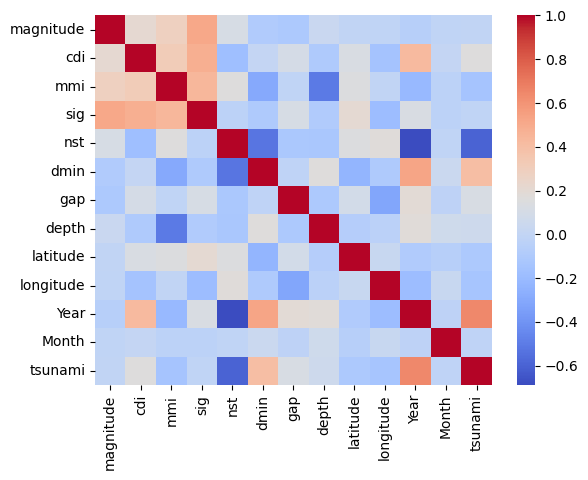

In [49]:
import seaborn as sns
sns.heatmap(tsunami.corr(), cmap='coolwarm')

Above, the correlation heatmap highlights relationships between our data, gives insight of the correlated variables and how seismic datasets commonly exhibit interesting patterns.

<Axes: xlabel='longitude', ylabel='latitude'>

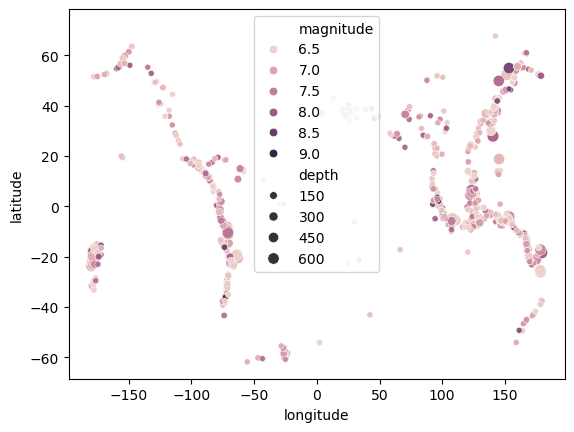

In [50]:
sns.scatterplot(data=tsunami, x='longitude', y='latitude', hue='magnitude', size='depth')

This scatterplot emphasizes regional exposure and how countries in the Pacific (Japan, Indonesia, Chile) dominate high-risk events.

As we can see from getting info on the dataset, our data is quite clean, there are no null or missing values and the data is numerical which we can analyze for exploration.

# Predicting Earthquake Strength/Magnitude using Regression

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingRegressor
!pip install xgboost
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

We are going to test each model's accuracy by running cross_val_score because it tests generalization - the ability of the model to perform on new data, not just the training set. The code below defines the cross validation object so every model is evaluated on identical folds, making the comparison fair.

In [52]:
#dont rerun, changes the random state
cv = KFold(n_splits=5, shuffle=True, random_state=42)

First, we're going to run a Random Forest Regression model because it handles non-linear relationships well (depth, latitude/longitude), is robust to noise which is common in seismic data, models complex interactions and performs well in most real-world scientific datasets.

In [53]:
X = tsunami.drop(['magnitude'], axis = 1)
y = tsunami['magnitude']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [54]:
reg_forest = RandomForestRegressor(n_estimators = 10, random_state = 42)
reg_forest.fit(X_train, y_train)
regf_pred = reg_forest.predict(X_test)
r2 = r2_score(y_test, regf_pred)
print("Random Forest R²:", r2)

Random Forest R²: 0.68815011107846


For this first regression model, we will examine the R squared value, while noting that it can be misleading if the model is overfitting the training data due to the single test split. To reduce bias and obtain a more reliable estimate of performance, we will use cross-validation from here on out.

In [55]:
cross_val_score(reg_forest, X, y, cv = cv).mean()

np.float64(0.6987632138402667)

The model performs pretty well with an accuracy of 69.9%.

Next, we are going to build an SVR with the RBF kernel because it captures smooth nonlinear dependencies such as depth-magnitude relationships which naturally arise in environmental data.

In [56]:
pipe = make_pipeline(StandardScaler(), SVR(kernel = 'rbf'))

grid = {
    'svr__C':[0.01, 1, 100],
    'svr__gamma':[0.01, 0.05, 1.0]
}

grid_search = GridSearchCV(estimator=pipe, param_grid=grid, cv=3, verbose=2)
grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END .......................svr__C=0.01, svr__gamma=0.01; total time=   0.0s
[CV] END .......................svr__C=0.01, svr__gamma=0.01; total time=   0.0s
[CV] END .......................svr__C=0.01, svr__gamma=0.01; total time=   0.0s
[CV] END .......................svr__C=0.01, svr__gamma=0.05; total time=   0.0s
[CV] END .......................svr__C=0.01, svr__gamma=0.05; total time=   0.0s
[CV] END .......................svr__C=0.01, svr__gamma=0.05; total time=   0.0s
[CV] END ........................svr__C=0.01, svr__gamma=1.0; total time=   0.0s
[CV] END ........................svr__C=0.01, svr__gamma=1.0; total time=   0.0s
[CV] END ........................svr__C=0.01, svr__gamma=1.0; total time=   0.0s
[CV] END ..........................svr__C=1, svr__gamma=0.01; total time=   0.0s
[CV] END ..........................svr__C=1, svr__gamma=0.01; total time=   0.0s
[CV] END ..........................svr__C=1, svr_

,estimator,"Pipeline(step...svr', SVR())])"
,param_grid,"{'svr__C': [0.01, 1, ...], 'svr__gamma': [0.01, 0.05, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [57]:
grid_search.best_params_

{'svr__C': 100, 'svr__gamma': 0.01}

In [58]:
best_model_svr = grid_search.best_estimator_
best_model_svr.fit(X_train, y_train)

,steps,"[('standardscaler', ...), ('svr', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,kernel,'rbf'
,degree,3
,gamma,0.01
,coef0,0.0


In [59]:
cross_val_score(best_model_svr, X, y, cv = cv).mean()

np.float64(0.5340439304440238)

The model explains about 53.4% of the variance which is decent but leaves room for improvement.

Lastly, we are going to try a XGBoost which utilizies gradient boosting, adding trees sequentially to correct previous errors. Even though we didn't specifically learn this model, we wanted to research it because when tuned, it offers the highest predictive accuracy. It's faster than a GBM due to parallel processing and a more efficient internal data structure.

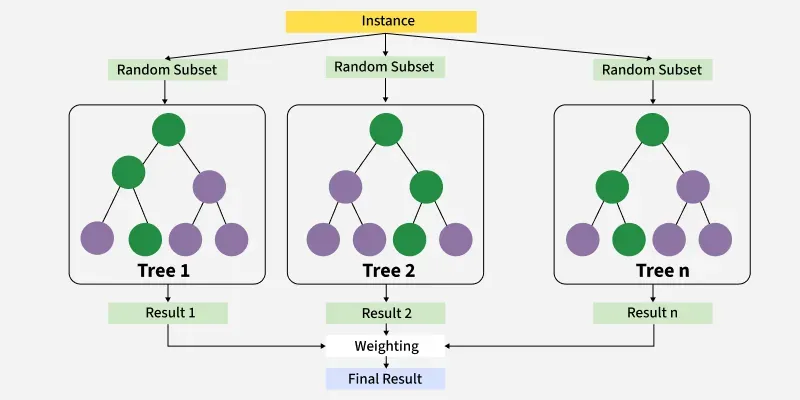

In [60]:
xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, subsample=0.9, colsample_bytree=0.8, objective='reg:squarederror', random_state=42)

xgb.fit(X_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


The parameters here are standard practice: n_estimators=500	gives enough trees for strong learning with low learning rate, learning_rate=0.05	guarantees stable learning and better generalization, max_depth=5	ensures balanced tree complexity, subsample=0.9	grabs 90% of the row data to prevent overfitting, colsample_bytree=0.8 grabs 80% of the features and is better for generalization, and objective='reg:squarederror'	clarifies the regression task.


In [61]:
cross_val_score(xgb, X, y, cv = cv).mean()

np.float64(0.7602891752177248)

The model yielded a 76.0% accuracy, but now we will tune the parameters to try to optimize the result.

In [62]:
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, verbose=2)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
best_model_xgb = grid_search.best_estimator_

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, subsample=0.9; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_d

Now we will compare the original and tuned model using the same CV splits, which guarantees both models are evaluated on identical folds, reducing bias.

In [63]:
cross_xgb = cross_val_score(xgb, X, y, cv=cv).mean()
print("Original Xgb: ", cross_xgb)
tuned_xgb = cross_val_score(best_model_xgb, X, y, cv=cv).mean()
print("Tuned Xgb: ", tuned_xgb)

Original Xgb:  0.7602891752177248
Tuned Xgb:  0.7443966239179087


The tuned model performs essentially the same as the original because the original hyperparameters were already strong. Thus, no meaningful improvement or decline occurred.

Based off the 3 regression models, the eXtreme Gradient Boosting model performed the best with 74.5% accuracy. Subsequently, we will check the final .score() of the model on unseen testing data to see how it does.

In [64]:
xgb.score(X_test, y_test)


0.7346629937790152

In conclusion, the best model, an extreme gradient boosting machine, explains around 73.5% of the variance in earthquake magnitude on unseen data.

# Predicting Tsunami's using Classification

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import ConfusionMatrixDisplay as cmd

We split the target variable, to make predictions with the data.

In [66]:
X = tsunami.drop(['tsunami'], axis = 1)
y = tsunami['tsunami']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Logistic Regression

In [114]:
reg = LogisticRegression(random_state=0, max_iter=10000)

reg = reg.fit(X_train, y_train)

y_preds = reg.predict(X_test)
accuracy = accuracy_score(y_test, y_preds)
accuracy

0.8535031847133758

For this first classification model, we will examine the accuracy score, while noting that it can be misleading if the model is overfitting the training data. To reduce bias and obtain a more reliable estimate of performance, we will use cross-validation from here on out.

In [113]:
cross_val_score(reg, X, y, cv=cv,).mean()

np.float64(0.8272987097827862)

This is a pretty good score, 82.7% prediction rate, but let's use a confusion matrix to get a visual of the data.

In [70]:
# This is to confirm which value the 0 and the 1 are corresponding with.
tsunami["tsunami"].value_counts()

tsunami
0    478
1    304
Name: count, dtype: int64

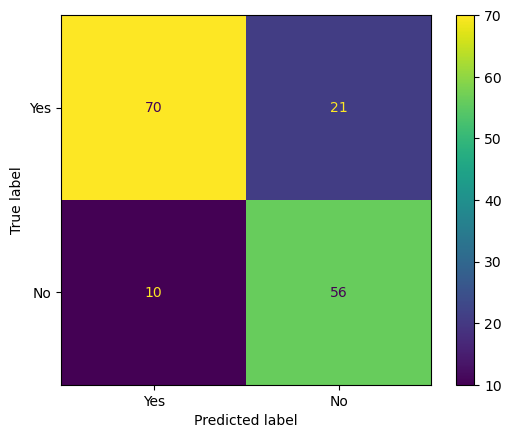

In [71]:
ConfusionMatrixDisplay.from_estimator(reg, X_test, y_test, display_labels=["Yes", "No"])

Our goal with this project is to predict the occurrence of tsunamis. We have trained and looked at a few models to see which ones would result in the best accuracy. We want to continue to try a few more models, such as a Decision Tree, Random Forest, GBM, SVM, and Neural Network to decipher which model performs the best.

Decision Tree

In [72]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [73]:
cross_val_score(tree, X, y, cv = cv).mean()

np.float64(0.9014617017801733)

The Decision Tree generated a 90.1% accuracy score.

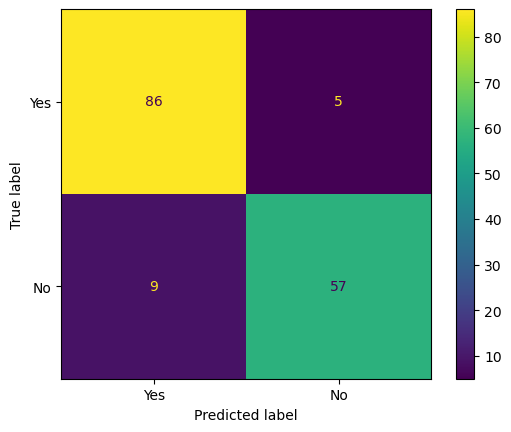

In [74]:
ConfusionMatrixDisplay.from_estimator(tree, X_test, y_test, display_labels=["Yes", "No"])

Random Forest

In [75]:
rf_model = RandomForestClassifier(n_estimators = 10, random_state = 0)
rf_model.fit(X_train, y_train)

,n_estimators,10
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [76]:
cross_val_score(rf_model, X, y, cv = cv).mean()

np.float64(0.8887228482769884)

The Random Forest achieved a 88.9% accuracy, meaning it correctly classified about 89% of the samples.

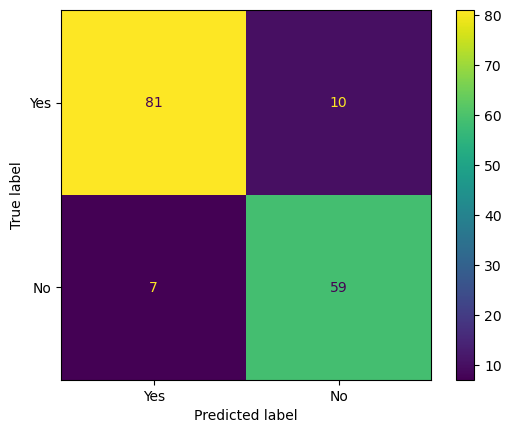

In [77]:
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, display_labels=["Yes", "No"])

Gradient Boosting Machine (Classifier)

In [78]:
#we use tree stumps which is a max depth of 1
gbc = GradientBoostingClassifier(max_depth = 1, random_state = 42)
gbc.fit(X_train, y_train)
gbc_preds = gbc.predict(X_test)
cross_val_score(gbc, X, y, cv = cv).mean()

np.float64(0.9181120365833741)

The Gradient Boosting Classifier yielded a 91.8% accuracy.

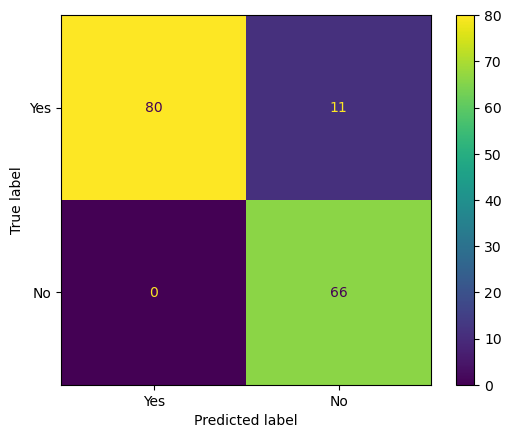

In [79]:
ConfusionMatrixDisplay.from_estimator(gbc, X_test, y_test, display_labels=["Yes", "No"])

Support Vector Machine (Classifier)

In [80]:
pipe = make_pipeline(StandardScaler(), SVC())

grid = {
    'svc__C':[0.01, 1, 100],
    'svc__gamma':[0.01, 0.05, 1.0],
    'svc__kernel': ['rbf', 'poly']
}

grid_search = GridSearchCV(estimator=pipe, param_grid=grid, cv=3, verbose=2)
grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ......svc__C=0.01, svc__gamma=0.01, svc__kernel=rbf; total time=   0.0s
[CV] END ......svc__C=0.01, svc__gamma=0.01, svc__kernel=rbf; total time=   0.0s
[CV] END ......svc__C=0.01, svc__gamma=0.01, svc__kernel=rbf; total time=   0.0s
[CV] END .....svc__C=0.01, svc__gamma=0.01, svc__kernel=poly; total time=   0.0s
[CV] END .....svc__C=0.01, svc__gamma=0.01, svc__kernel=poly; total time=   0.0s
[CV] END .....svc__C=0.01, svc__gamma=0.01, svc__kernel=poly; total time=   0.0s
[CV] END ......svc__C=0.01, svc__gamma=0.05, svc__kernel=rbf; total time=   0.0s
[CV] END ......svc__C=0.01, svc__gamma=0.05, svc__kernel=rbf; total time=   0.0s
[CV] END ......svc__C=0.01, svc__gamma=0.05, svc__kernel=rbf; total time=   0.0s
[CV] END .....svc__C=0.01, svc__gamma=0.05, svc__kernel=poly; total time=   0.0s
[CV] END .....svc__C=0.01, svc__gamma=0.05, svc__kernel=poly; total time=   0.0s
[CV] END .....svc__C=0.01, svc__gamma=0.05, svc_

,estimator,"Pipeline(step...svc', SVC())])"
,param_grid,"{'svc__C': [0.01, 1, ...], 'svc__gamma': [0.01, 0.05, ...], 'svc__kernel': ['rbf', 'poly']}"
,scoring,None
,n_jobs,None
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [81]:
best_model_svc = grid_search.best_estimator_
best_model_svc.fit(X_train, y_train)

,steps,"[('standardscaler', ...), ('svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,C,100
,kernel,'rbf'
,degree,3
,gamma,0.01


In [82]:
cross_val_score(best_model_svc, X, y, cv=cv).mean()

np.float64(0.8631308182263597)

As a result, the support vector machine yields a 86.3% classification accuracy on predicting if there was a tsunami or not.

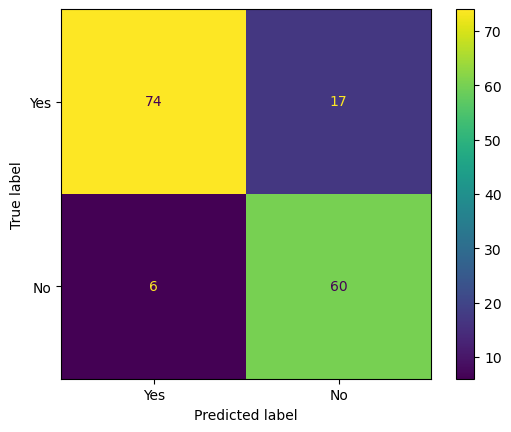

In [83]:
ConfusionMatrixDisplay.from_estimator(best_model_svc, X_test, y_test, display_labels=["Yes", "No"])

Neural Network

In [103]:
!pip install --upgrade scikit-learn scikeras

In [104]:
!pip install tensorflow

In [86]:
!pip install scikeras

import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import GridSearchCV

We created a function that defines the neural network structure used in the grid search. The function allows GridSearchCV to rebuild and evaluate models of different sizes to determine which configuration performs best.

The function takes ***num_nodes*** as an input so the grid search can adjust the size of the hidden layers and compare different model capacities.

In [87]:
def create_model(num_nodes=1):
  model = Sequential()
  model.add(Input(shape=(12,)))
  model.add(Dense(num_nodes, activation='relu'))
  model.add(Dense(num_nodes, activation= 'relu'))

  model.add(Dense(1, activation='sigmoid'))

  # use binary_crossentropy loss and accuracy metric, because this is a binary model
  model.compile(optimizer = 'adam', loss= 'binary_crossentropy', metrics=['accuracy'])

  return model


In this section of the project, we created a parameter grid that GridSearchCV uses to test different versions of my neural network model. The goal is to identify which combination of hyperparameters gives the best predictive performance.

In [88]:
param_grid = {
    "model__num_nodes": [250,512,820],
    "batch_size": [75,100,150],
}

In [89]:
model = KerasClassifier(model=create_model, epochs=5, verbose=0)

In [90]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_result = grid.fit(X_train, y_train)

After GridSearchCV completes its hyperparameter search, this code takes the best-performing set of parameters and its corresponding accuracy score. The variable ***bestParam*** stores the combination of hyperparameters, *batch_size* and *num_nodes* that produced the highest cross-validated accuracy, and bestAcc holds that accuracy value.

In this case, the grid search determined that using a batch size of 75 and 820 hidden-layer nodes produced the most accurate model, achieving an average cross-validation accuracy of 0.7984.

Using this information guides us toward the optimal model and training setup for building our final neural network.

In [91]:
bestParam = grid_result.best_params_
bestAcc = grid_result.best_score_
print("Best Parameters to use: ", bestParam)
print("Best Score: ", bestAcc)

Best Parameters to use:  {'batch_size': 75, 'model__num_nodes': 512}
Best Score:  0.7952


The Neural Network resulted in a 79.5% accuracy.

In [92]:
model.fit(X_train, y_train)
model.model_.summary()

Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_138 (Dense)               │ (None, 1)              │            13 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_139 (Dense)               │ (None, 1)              │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_140 (Dense)               │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53 (216.00 B)

 Trainable params: 17 (68.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 36 (148.00 B)

In [105]:
#from tensorflow.keras.models import load_model

#model = load_model('my_model.keras')

The confusion matrix shows that the model performs well overall, with strong accuracy in predicting both classes, but it does so with a  bias toward predicting “No.” It correctly identifies most negative cases, so it doesn't produce many false positives, which suggests the model is reliable when it predicts “Yes.” However, it misses a number of actual “Yes” cases, resulting in a higher false negative count.

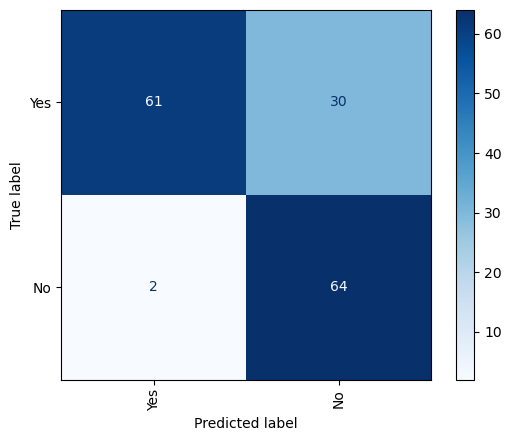

In [100]:
best_model = grid_result.best_estimator_

sns.reset_orig()
y_predicted = best_model.predict(X_test) > 0.5
labels = ['Yes', 'No']
cmd.from_predictions(y_test, y_predicted, display_labels=labels, cmap='Blues', xticks_rotation='vertical')
plt.show()

In [95]:
model = Sequential()

model.add(Dense(812, activation='relu', input_dim=12))
model.add(Dense(812, activation= 'relu'))

model.add(Dense(1, activation='sigmoid'))

# use binary_crossentropy loss and accuracy metric, because this is a binary model
model.compile(optimizer = 'adam', loss= 'binary_crossentropy', metrics=['accuracy'])

C:\Users\tiaar\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [96]:
model.summary()

Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_141 (Dense)               │ (None, 812)            │        10,556 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 812)            │       660,156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 1)              │           813 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 671,525 (2.56 MB)

 Trainable params: 671,525 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

In [97]:
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=75, epochs=10)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.5904 - loss: 133.8853 - val_accuracy: 0.7580 - val_loss: 15.9117
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6144 - loss: 38.1002 - val_accuracy: 0.6051 - val_loss: 13.6631
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7632 - loss: 22.0727 - val_accuracy: 0.5796 - val_loss: 16.6204
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7424 - loss: 13.6093 - val_accuracy: 0.7898 - val_loss: 8.3096
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7856 - loss: 9.0288 - val_accuracy: 0.8153 - val_loss: 5.5381
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7920 - loss: 5.1160 - val_accuracy: 0.6306 - val_loss: 3.7883
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7808 - loss: 3.2985 - val_accuracy: 0.6815 - val_loss: 1.4721
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6896 - loss: 3.2269 - val_accuracy: 0.5350 - val_loss:

In [ ]:
#model.save('my_model')

In [ ]:
#from tensorflow.keras.models import load_model

#model = load_model('my_model')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


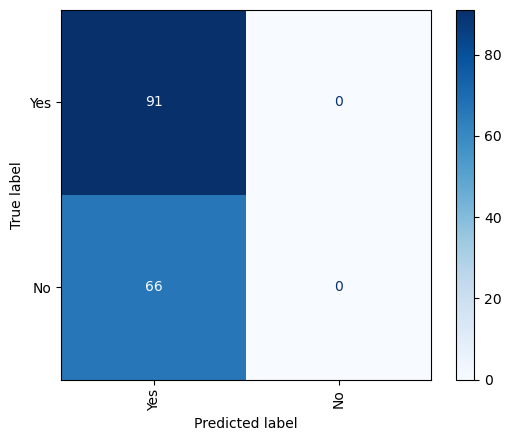

In [101]:
sns.reset_orig()
y_predicted = model.predict(X_test) > 0.5
labels = ['Yes', 'No']
cmd.from_predictions(y_test, y_predicted, display_labels=labels, cmap='Blues', xticks_rotation='vertical')
plt.show()

In [116]:
import pickle
#saving the model somewhere else, into a file 'wb' is to write to the file
pickle.dump(gbc, open('bestModel.pkl', 'wb'))

# Results

In conclusion, our analysis confirms that gradient boosting models outperformed all other tested algorithms in both regression and classification tasks, demonstrating superior capability in handling complex seismic data.

Earthquake Magnitude (Regression): The XGBoost model was the clear leader, achieving a test-set cross validation score of 75.9%. It explained nearly 76% of the variance on unseen data, significantly outperforming Random Forests (~69.9%) and SVR (~53.4%).

Tsunami Prediction (Classification): The Gradient Boosting Classifier achieved the highest reliability with an accuracy of 91.8%. While Decision Trees (89.2%) and Random Forests (88.9%) performed well, Gradient Boosting provided the best overall prediction of tsunami occurrence.

While models like Random Forest and Decision Trees performed reasonably well, they were consistently outperformed by boosting methods. This suggests that the mechanism of boosting is uniquely suited for the high variance and noise of geophysical datasets.

The success of these models is attributed to their structure. By iteratively correcting errors from previous steps, boosting methods effectively handle the nonlinear and noisy patterns in the geophysical dataset, resulting in the best results for preditions.